# Exercise: Gaussian Process models with GPy

Adapted from Christian Forssen, TALENT Course 11, June, 2019, which was
adapted from the Gaussian Process Summer School (written by Nicolas Durrande, Neil Lawrence and James Hensman).

Additions by Dick Furnstahl in November, 2019.

The aim of this exercise is to illustrate the concepts of Gaussian processes. We will focus on three aspects of GPs: the kernel, the random sample paths and the GP regression model.

We will use the well known [GPy package](https://sheffieldml.github.io/GPy/) by the Sheffield ML group.

The current draft of the online documentation of GPy is available from [this page](http://gpy.readthedocs.org/en/latest/).

### Import modules

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(); sns.set_context("talk")

import GPy

## 1 Getting started: The Covariance Function

Let's start with defining an exponentiated quadratic covariance function (also known as squared exponential or rbf or Gaussian) in one dimension:

In [2]:
d = 1          # input dimension
var = 1.       # variance
theta = 0.2    # lengthscale
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)

A summary of the kernel can be obtained using the command `print k`. 

In [3]:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.2  |      +ve      |        


It is also possible to plot the kernel as a function of one of its inputs (whilst fixing the other) with `k.plot()`.

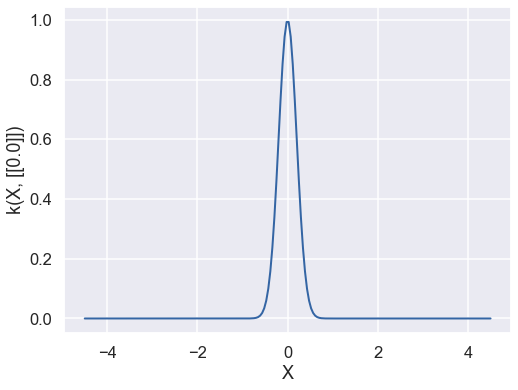

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
k.plot(ax = ax);

## Setting Covariance Function Parameters

The value of the covariance function parameters can be accessed and modified using `k['.*var']` where the string in bracket is a regular expression matching the parameter name as it appears in `print(k)`. Let's use this to get an insight into the effect of the parameters on the shape of the covariance function. 

We'll now use it to set the lengthscale of the covariance to different values, and then plot the resulting covariance using the `k.plot()` method.

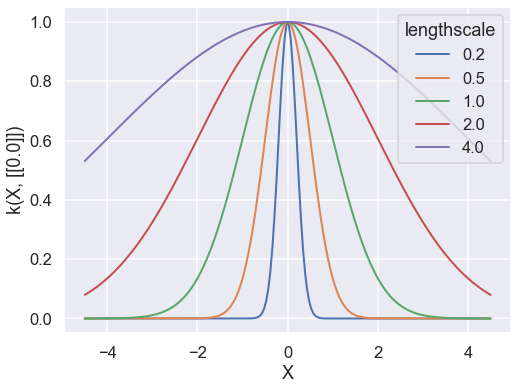

In [5]:
k = GPy.kern.RBF(d)     # By default, the parameters are set to 1.
theta = np.asarray([0.2, 0.5, 1., 2., 4.])

fig, ax = plt.subplots(figsize=(8,6))
for it, t in enumerate(theta):
    k.lengthscale = t
    k.plot(ax=ax, color=f"C{it}")
    plt.legend(theta, title='lengthscale')

### Exercise 1

a) What is the effect of the lengthscale parameter on the covariance function?

b) First predict how the graphs will change if you replace `k.lengthscale` by `k.variance`, i.e., predict the effect of the variance parameter on the covariance function.  Then make the change and check. 

In [6]:
# Exercise 1 b) answer
# insert revised code here (change the legend label as well)




## Covariance Functions in GPy

Many covariance functions are already implemented in GPy. Instead of rbf, try constructing and plotting the following  covariance functions: `exponential`, `Matern32`, `Matern52`, `Brownian`, `linear`, `bias`,
`rbfcos`, `periodic_Matern32`, etc. Some of these covariance functions, such as `rbfcos`, are not
parametrized by a variance and a lengthscale. Furthermore, not all kernels are stationary (i.e., they can’t all be written as $k ( x, y) = f ( x − y)$, see for example the Brownian
covariance function). For plotting  so it may be interesting to change the value of the fixed input:

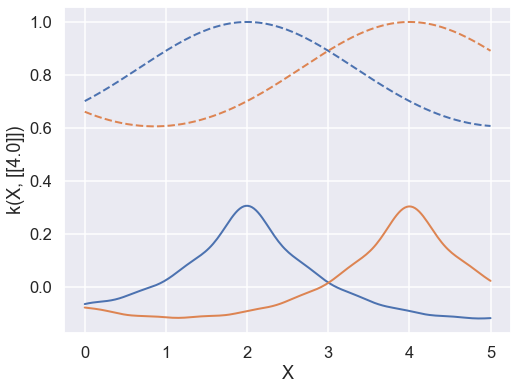

In [7]:
kb1 = GPy.kern.PeriodicExponential(input_dim=1, variance=1.0, 
                                   lengthscale=1.0, period=6.28)
kb2 = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, 
                           lengthscale=1.0, period=6.28)
inputs = np.array([2., 4.])

fig, ax = plt.subplots(figsize=(8,6))
for ix, x in enumerate(inputs):
    kb1.plot(x,plot_limits=[0,5],ax=ax,color=f"C{ix}")
    kb2.plot(x,plot_limits=[0,5],ax=ax,color=f"C{ix}",linestyle='--')

## Computing the Covariance Function given the Input Data, $\mathbf{X}$

Let $\mathbf{X}$ be a $n$ × $d$ numpy array. Given a kernel $k$, the covariance matrix associated to
$\mathbf{X}$ is obtained with `C = k.K(X,X)`. The positive semi-definiteness of $k$ ensures that `C`
is a positive semi-definite (psd) matrix regardless of the initial points $\mathbf{X}$. This can be
checked numerically by looking at the eigenvalues (the log of the eigenvalues is plotted below, so no
error means the eigenvalues are all positive):

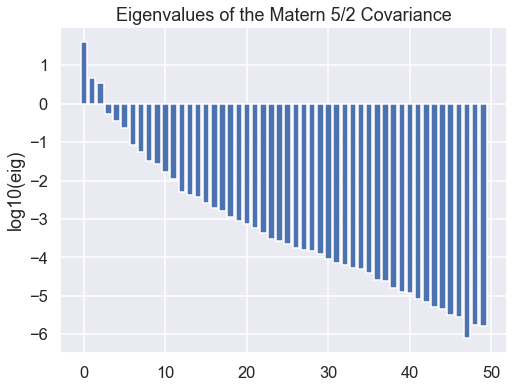

In [8]:
k = GPy.kern.Matern52(input_dim=2)
X = np.random.rand(50, 2)        # 50*2 matrix of 2d standard Gaussians
C = k.K(X,X)                     # covariance matrix
eigvals = np.linalg.eigvals(C)   # Computes the eigenvalues of a matrix

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(np.arange(len(eigvals)), np.log10(eigvals))
my_title = 'Eigenvalues of the Matern 5/2 Covariance'
ax.set(ylabel='log10(eig)', title=my_title);

### Follow-up task

*Check this property for some other kernel and for a different set of points*




## Combining Covariance Functions

### Exercise 2

a) A matrix, $\mathbf{K}$, is positive semi-definite if the matrix inner product, $\mathbf{x}^\top \mathbf{K}\mathbf{x}$ is greater than or equal to zero regardless of the values in $\mathbf{x}$. Given this it should be easy to see that the sum of two positive semi-definite matrices is also positive semi-definite. In the context of Gaussian processes, this is the sum of two covariance functions. What does this mean from a modelling perspective? 

*Hint*: there are actually two related interpretations for this. Think about the properties of a Gaussian distribution, and in what situation the sum of Gaussian variances arises.

b) What about the element-wise product of two covariance functions? In other words if we define

\begin{align*}
k(\mathbf{x}, \mathbf{x}^\prime) = k_1(\mathbf{x}, \mathbf{x}^\prime) \, k_2(\mathbf{x}, \mathbf{x}^\prime)
\end{align*}

then is $k(\mathbf{x}, \mathbf{x}^\prime)$ a valid covariance function?

### Combining Covariance Functions in GPy

In GPy you can easily combine covariance functions you have created using the sum and product operators, `+` and `*`. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


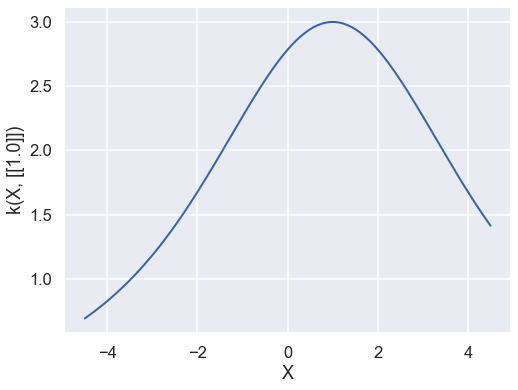

In [9]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)
kern = kern1 + kern2
print(kern)
fig, ax = plt.subplots(figsize=(8,6))
kern.plot(ax=ax);

Or if we wanted to multiply them we can write

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


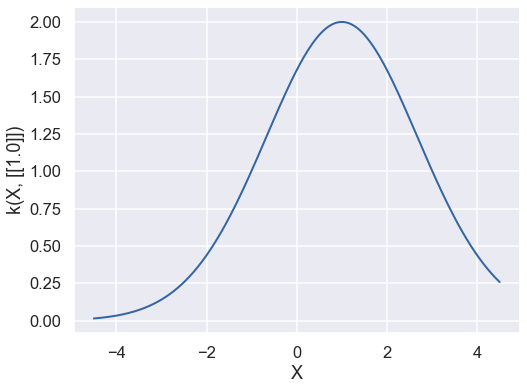

In [10]:
kern = kern1*kern2
print(kern)
fig, ax = plt.subplots(figsize=(8,6))
kern.plot(ax=ax);

## 2 Sampling from a Gaussian Process

The Gaussian process provides a prior over an infinite dimensional function. It is defined by a covariance *function* and a mean *function*. When we compute the covariance matrix using `kern.K(X, X)` we are computing a covariance *matrix* between the values of the function that correspond to the input locations in the matrix `X`. If we want to have a look at the type of functions that arise from a particular Gaussian process we can never generate all values of the function, because there are infinite values. However, we can generate samples from a Gaussian *distribution* based on a covariance matrix associated with a particular matrix of input locations `X`. If these locations are chosen appropriately then they give us a good idea of the underlying function. For example, for a one dimensional function, if we choose `X` to be uniformly spaced across part of the real line, and the spacing is small enough, we'll get an idea of the underlying function. We will now use this trick to draw sample paths from a Gaussian process. 

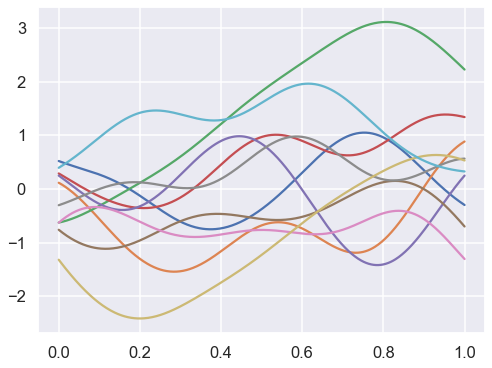

In [11]:
k = GPy.kern.RBF(input_dim=1, lengthscale=0.2)

# define X to be 500 points evenly spaced over [0,1]
X = np.linspace(0., 1., 500) 
# reshape X to make it n*p --- GPy uses 'design matrices'
X = X[:,None]    # now 500 x 1  

mu = np.zeros(len(X)) # vector of the means --- we could use a mean function here, but here it is just zero.
C = k.K(X,X) # compute the covariance matrix associated with inputs X

# Generate 'nsamples' separate samples paths from a Gaussian with mean mu and covariance C
nsamples=10
Z = np.random.multivariate_normal(mu,C,nsamples)

fig, ax = plt.subplots(figsize=(8,6))
for i in range(nsamples):
    ax.plot(X[:],Z[i,:]);

Our choice of `X` means that the points are close enough together to look like functions. We can see the structure of the covariance matrix we are plotting from if we visualize C.

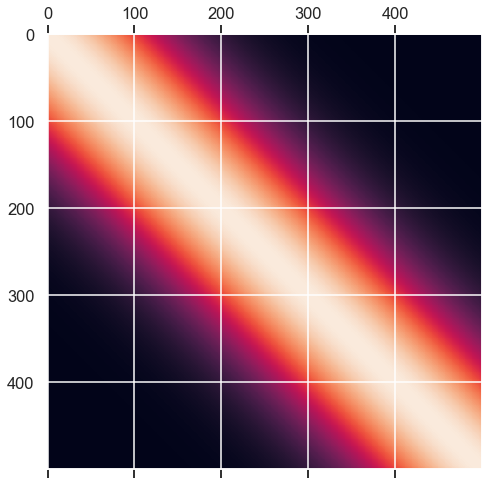

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.matshow(C);

*Predict what the plot will look like for `nsamples=50` and then `nsamples=500`.  Try it!*

*Predict what will happen if you replace <br>
    `mu = np.zeros(len(X))` <br>
by <br>
    `mu = np.linspace(-1., 1., len(X))` <br>
and then do it.*

### Exercise 3

*Modify the code below so that it plots the sampled paths from the nine different covariance structures that are generated.* 

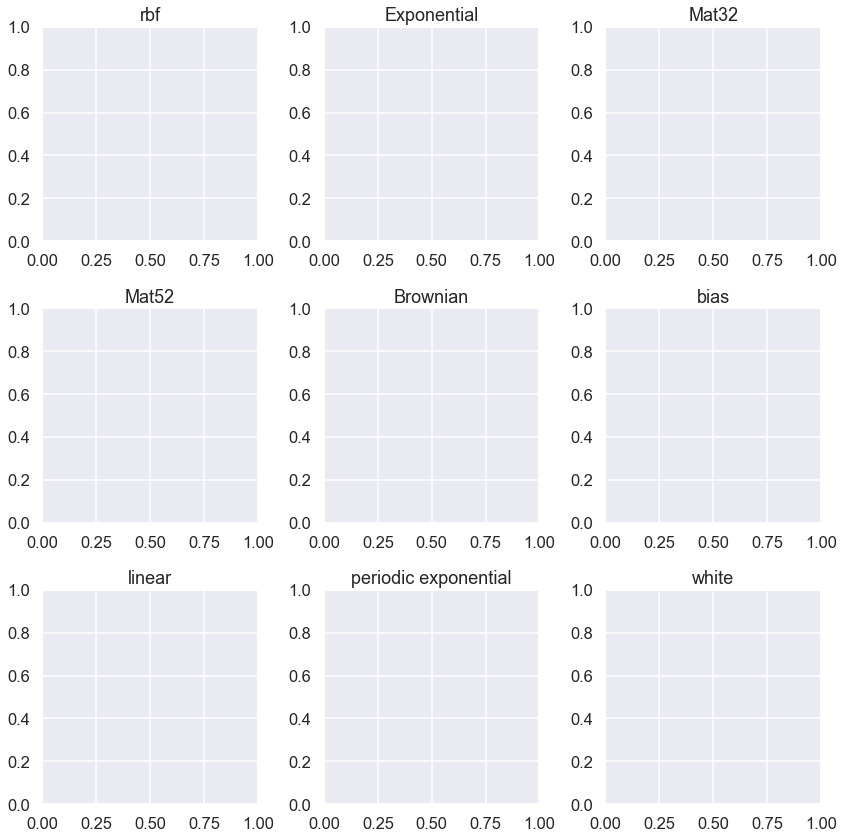

In [13]:
figure, axes = plt.subplots(3,3, figsize=(12,12), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), 
         GPy.kern.Matern52(1), GPy.kern.Brownian(1), GPy.kern.Bias(1), 
         GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), 
         GPy.kern.White(1)]


X = np.linspace(0.,1.,500) 
X = X[:,None] 

# We could use a mean function here, but here it is just zero.
mu = np.zeros(len(X))  # vector of the means 

nsamples=10    
    
for k,a in zip(kerns, axes.flatten()):
    C = k.K(X,X)   # compute the covariance matrix associated with inputs X
    Z = np.random.multivariate_normal(mu,C,nsamples)
    a.set_title(k.name.replace('_', ' '))
    # Fill in code here using previous code as a prototype:
    #  we need to plot the nsamples on the current axis a


## 3 A Gaussian Process Regression Model

We will now combine the Gaussian process prior with some data to form a GP regression model with GPy. We will generate data from the function $f ( x ) = − \cos(\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

(0.0, 1.0)

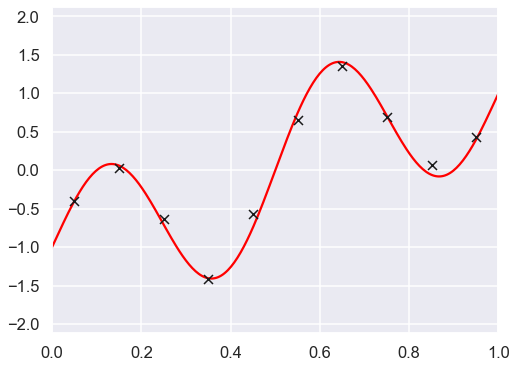

In [14]:
def Yfunc(X):
    """Test function for GP regression model calibration."""
    return -np.cos(np.pi * X) + np.sin(4 * np.pi * X) 

X = np.linspace(0.05, 0.95, 10)[:,None]
Y = Yfunc(X) + np.random.normal(loc=0.0, scale=0.1, size=(10,1)) 

# Use many points over a larger range for the true arrays
Xtrue = np.linspace(-0.4, 1.4 ,500)
Ytrue = Yfunc(Xtrue)


X = np.linspace(0.05, 0.95, 10)[:,None]
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
     np.random.normal(loc=0.0, scale=0.1, size=(10,1)) 
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Xtrue, Ytrue, color='red')
ax.plot(X, Y, 'kx', mew=1.5);
ax.set_xlim(0., 1.)


A GP regression model based on an exponentiated quadratic covariance function can be defined by first defining a covariance function, 

In [15]:
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

And then combining it with the data to form a Gaussian process model,

In [16]:
m = GPy.models.GPRegression(X, Y, k)

Just as for the covariance function object, we can find out about the model using the command `print(m)`. 

In [17]:
print(m)


Name : GP regression
Objective : 13.150838809832631
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that by default the model includes some observation noise
with variance 1. We can see the posterior mean prediction and visualize the marginal posterior variances using `m.plot()`.

**Note:** The `plot` command shows the mean of the GP model as well as the 95% confidence region.

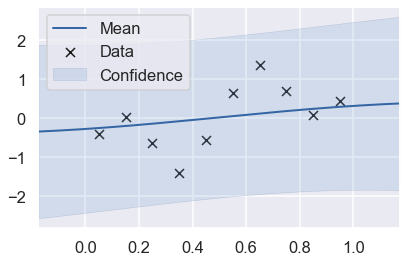

In [18]:
m.plot();

The actual predictions of the model for a set of points `Xnew` can be computed using 
```python
Ynew, Yvar = m.predict(Xnew)
```

Note that `Xnew` is an $m \times p$ array, where $m$ is the number of points that we want to predict and $p$ is the dimensionality of the parameter space.

We can also extract the predictive quantiles around the prediction at `Xnew`.
```python
Ylo95, Yhi95 = m.predict_quantiles(Xnew)
```


In [19]:
Xnew = np.linspace(0.0, 1.5, 4)[:,None]
(Ymean,Yvar) = m.predict(Xnew)

# quantiles=(2.5, 97.5) are default
(Ylo95, Yhi95) = m.predict_quantiles(Xnew)

print(r"  X   mean Y   var Y   lo95%   hi95%")
for (Xi, Ymeani, Yvari, Yloi, Yhii) in zip(Xnew, Ymean, Yvar, Ylo95, Yhi95):
    print(f"{Xi[0]:5.2f}  {Ymeani[0]:5.2f}   {Yvari[0]:5.2f}   ", end='')
    print(f"{Yloi[0]:5.2f}   {Yhii[0]:5.2f}")

  X   mean Y   var Y   lo95%   hi95%
 0.00  -0.28    1.20   -2.43    1.87
 0.50   0.02    1.10   -2.04    2.07
 1.00   0.31    1.20   -1.84    2.46
 1.50   0.42    1.48   -1.96    2.80


### Exercise 4

a) What do you think about this first fit? Does the prior given by the GP seem to be
adapted?

b) The parameters of the models can be modified using a regular expression matching the parameters names (for example `m['Gaussian_noise.variance'] = 0.001` ). Change the values of the parameters to obtain a better fit.

In [20]:
# Exercise 4 b) 
# make a plot for a better fit here




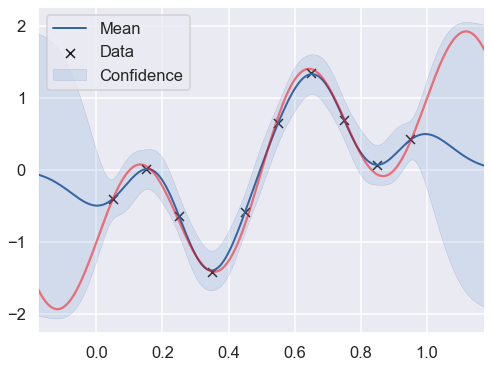

In [21]:
# KEY
m['Gaussian_noise.variance'] = 0.01
m['rbf.lengthscale'] = 0.1
fig, ax = plt.subplots(figsize=(8,6))
m.plot(ax=ax)
ax.plot(Xtrue, Ytrue, color='red', alpha=0.5);


c) As in Section 2, random sample paths from the conditional GP can be obtained using
`np.random.multivariate_normal(mu[:,0],C)` where the mean vector and covariance
matrix `mu`, `C` are obtained through the predict function `mu, C = m.predict(Xp,full_cov=True)`. Obtain 20 samples from the posterior sample and plot them alongside the data below. Compare the random sample paths to the 95% confidence region that is shown with the `m.plot()` command.

In [22]:
# Exercise 4 c) answer




### Covariance Function Parameter Estimation

The kernel parameter values can be estimated by maximizing the *likelihood* of the observations. Since we don’t want one of the variances to become negative during the optimization, we can constrain all parameters to be positive before running the optimisation.

In [23]:
m.constrain_positive()

reconstraining parameters GP_regression


The warnings are because the parameters are already constrained by default, the software is warning us that they are being reconstrained.

Now we can optimize the model using the `m.optimize()` method.


Name : GP regression
Objective : 7.064449026853923
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.6420915351337627  |      +ve      |        
  rbf.lengthscale          |    0.11884188044603256  |      +ve      |        
  Gaussian_noise.variance  |  8.287694660306663e-10  |      +ve      |        


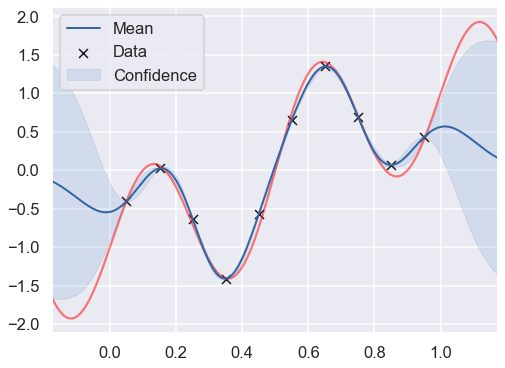

In [24]:
m.optimize()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Xtrue, Ytrue, color='red', alpha=0.5)
m.plot(ax=ax)
print(m)

The parameters obtained after optimisation can be compared with the values selected by hand above. As previously, you can modify the kernel used for building the model to investigate its influence on the model.

## 4 A Running Example

Now we'll consider a small example with real world data, data giving the pace of all marathons run at the olympics. To load the data use

In [25]:
GPy.util.datasets.authorize_download = lambda x: True 
                          # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
print(data['details'])

Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data


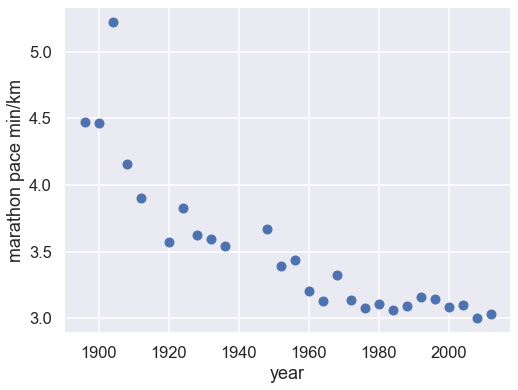

In [26]:
X = data['X']
Y = data['Y']
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X, Y,'o')
ax.set(xlabel='year',ylabel='marathon pace min/km');

### Exercise 5

a) Build a Gaussian process model for the olympic data set using a combination of an exponentiated quadratic and a bias covariance function. Fit the covariance function parameters and the noise to the data. Plot the fit and error bars from 1870 to 2030. Do you think the predictions are reasonable? If not why not?

Compute also the log likelihood for the optimum.

*Hint:* use `model.log_likelihood()` for computing the log likelihood.

In [27]:
# Exercise 5 a) answer 
# Enter code here




b) Fit the same model, but this time initialize the length scale of the exponentiated quadratic to 0.5. What has happened? Which model has the higher log likelihood, this one or the one from (a)? 

*Hint:* use `model.log_likelihood()` for computing the log likelihood.

In [28]:
# Exercise 5 b) answer
# Enter code here




c) Modify your model by including two covariance functions. Initialize a covariance function with an exponentiated quadratic part, a Matern 3/2 part and a bias covariance. Set the initial length scale of the exponentiated quadratic to 80 years, set the initial length scale of the Matern 3/2 to 10 years. Optimize the new model and plot the fit again. How does it compare with the previous model? 

In [29]:
# Exercise 5 c) answer
# Enter code here




d) Repeat part c) but now initialize both of the covariance functions' length scales to 20 years. Check the model parameters, what happens now? 

In [30]:
# Exercise 5 d) answer
# Enter code here




e) Now model the data with a product of an exponentiated quadratic covariance function and a linear covariance function. Fit the covariance function parameters. Why are the variance parameters of the linear part so small? How could this be fixed?

In [31]:
# Exercise 5 e) answer
# Enter code here


